# AT&T Spam Detector
Comment détecter les spams ?

## Importing libraries

In [45]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import tensorflow as tf

from sklearn.model_selection import train_test_split

from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split

from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from wordcloud import WordCloud

In [46]:
df = pd.read_csv('src/spam.csv', encoding = "ISO-8859-1")

## EDA

In [47]:
print("Display of 5 first rows: ")
display(df.head())
print()

print("Basics statistics: ")
data_desc = df.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*df.isnull().sum()/df.shape[0])

Display of 5 first rows: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN



Basics statistics: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2



Percentage of missing values: 


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

In [48]:
df["Unnamed: 4"].count()
df_colonne_sans_nan = df.dropna(subset=['Unnamed: 4'])['Unnamed: 4']
print(df_colonne_sans_nan.count())

6


In [49]:
#Replacing Nan by empty values and Concatenate all columns into one
df['Unnamed: 2'] = df['Unnamed: 2'].fillna("")
df['Unnamed: 3'] = df['Unnamed: 3'].fillna("")
df['Unnamed: 4'] = df['Unnamed: 4'].fillna("")
df['v2']=pd.concat([df['v2'],df['Unnamed: 2'],df['Unnamed: 3'],df['Unnamed: 4']], ignore_index=True)

#Keeping just the two first columns
df = df[['v1','v2']]
df.tail()

,v1,v2
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


In [50]:
df=df.rename(columns={'v1':'Type','v2':'Messages'})

In [51]:
df.Type.value_counts()

Type
ham     4825
spam     747
Name: count, dtype: int64

AttributeError: 'Axes' object has no attribute 'bar_Type'

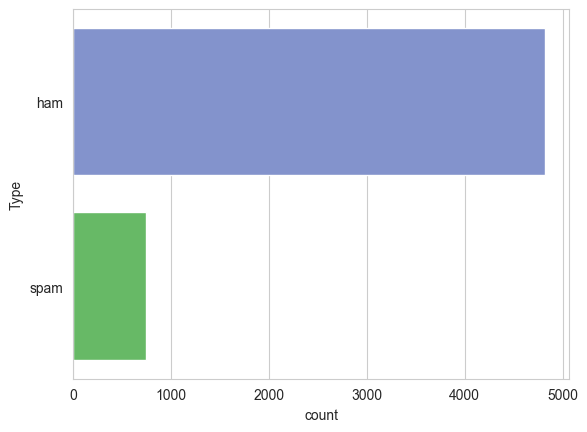

In [52]:
ax = sns.countplot(df['Type'], palette=['#778cd8',"#59c758"])
for container in ax.containers:
    ax.bar_Type(container)
plt.title('Target Type count', fontdict={'color':'#410d88'})
plt.show()

In [ ]:
# Compter le nombre d'occurrences de chaque catégorie dans la colonne 'Type'
comptages_type = df['Type'].value_counts()

# Créer un camembert avec les comptages
plt.figure(figsize=(8, 8))  # Définir la taille de la figure
plt.pie(comptages_type, Types=comptages_type.index, autopct='%1.1f%%', startangle=140)

# Ajouter un titre
plt.title('Répartition des messages suivant leur type')

# Afficher le camembert
plt.axis('equal')  # Assurer que le camembert est circulaire
plt.show()

TypeError: pie() got an unexpected keyword argument 'Types'

<Figure size 800x800 with 0 Axes>

In [ ]:
df['Type'] = df['Type'].map( {'spam': 1, 'ham': 0} )
df.head()

,Type,Messages
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df['word_count'] = df['Messages'].apply(lambda x : len(x.split(' ')))

In [ ]:
df.groupby('Type')['word_count'].agg(['count', 'mean', 'median'])

,count,mean,median
Type,,,
0,4825,14.323938,11.0
1,747,23.892905,25.0


In [ ]:
df['word_count'].max()

171

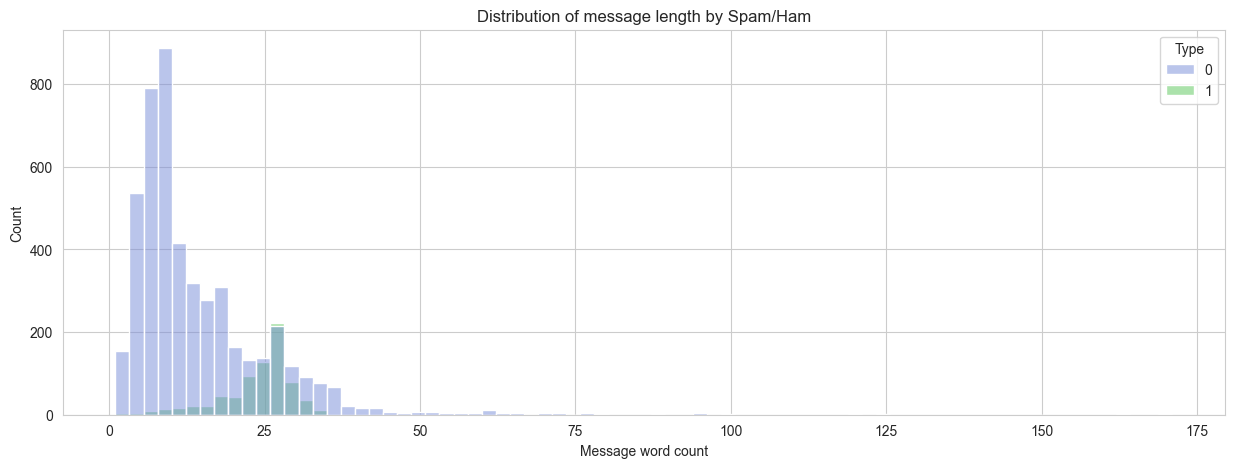

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(15,5))
sns.histplot(data=df, 
             x="word_count",
             hue="Type",
             bins=75,
             palette=['#778cd8',"#59c758"],
             legend=True).set_title('Distribution of message length by Spam/Ham')

# Ajouter des étiquettes d'axe
plt.xlabel('Message word count')
plt.ylabel('Count')
plt.show()

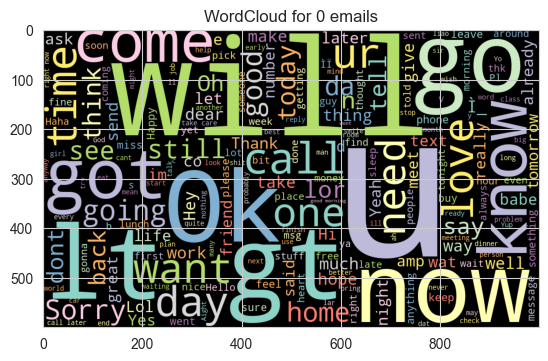

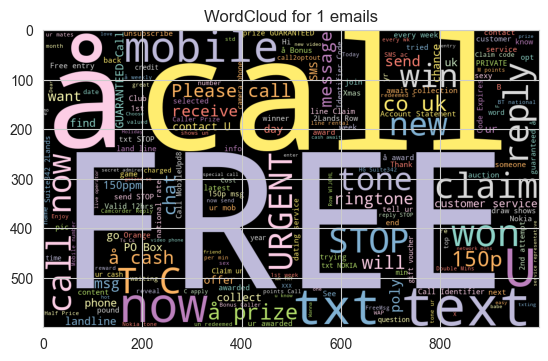

In [ ]:
for i in set(df['Type']):
    words = ''
    for document in df[df['Type'] == i]['Messages']:
        words += document + ' '
    wordcloud = WordCloud(width=1000, height=600, background_color='black', colormap='Set3').generate(words)
    plt.imshow(wordcloud)
    plt.title("WordCloud for {} emails".format(i))
    plt.show()

## Preprocessing datas

### Lemmatizing** to keep only the most important words on the good form.

In [ ]:
import spacy

In [ ]:
nlp = spacy.load("en_core_web_sm")
#import en_core_web_sm
#nlp = en_core_web_md.load()

In [ ]:
df["clean_content"] = df["Messages"].apply(
    lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'")
    )

df["clean_content"] = df["clean_content"].apply(
    lambda x: x.replace(" +"," ").lower().strip()
    )

df["clean_content"] = df["clean_content"].apply(
    lambda x: " ".join([token.lemma_ for token in nlp(x) \
    if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)])
    )

In [ ]:
liste_texte = df['clean_content'].tolist()
corpus=[]
corpus.extend(liste_texte)


In [ ]:
corpus

['jurong point crazy available bugis n great world la e buffet cine amore wat',
 'ok lar joke wif u oni',
 'free entry 2 wkly comp win fa cup final tkts 21st 2005 text fa 87121 receive entry questionstd txt ratetc apply 08452810075over18',
 'u dun early hor u c',
 'nah think usf live',
 'freemsg hey darle 3 week word like fun tb ok xxx std chgs send å150 rcv',
 'brother like speak treat like aids patent',
 "request ' melle melle oru minnaminunginte nurungu vettam ' set callertune caller press 9 copy friend callertune",
 'winner value network customer select receivea å900 prize reward claim 09061701461 claim code kl341 valid 12 hour',
 'mobile 11 month u r entitle update late colour mobile camera free mobile update co free 08002986030',
 'home soon want talk stuff anymore tonight k cry today',
 'chance win cash 100 20000 pound txt csh11 send 87575 cost 150pday 6days 16 tsandc apply reply hl 4 info',
 'urgent win 1 week free membership å100000 prize jackpot txt word claim 81010 tc wwwdbu

In [ ]:
premiere_valeur_messages = df.iloc[0]['clean_content']


In [ ]:
premiere_valeur_messages

'jurong point crazy available bugis n great world la e buffet cine amore wat'

In [ ]:
stop_words = nlp.Defaults.stop_words

# Afficher les mots vides
print(stop_words)

{'‘s', 'last', 'those', 'enough', 'an', '’d', 'becomes', 'moreover', 'above', 'via', 'who', 'more', 'yourself', 'several', 'anyway', 'to', 'third', 'each', 'name', 'even', 'eleven', 'her', 'thereafter', 'give', 'these', 'amongst', 'doing', 'themselves', 'then', 'else', 'something', 'never', 'ever', 'they', 'herein', 'make', 'along', 'is', 'in', 'take', 'may', 'whether', 'just', 'although', 'n‘t', 'whence', 'say', 'seeming', 'under', 'against', 'within', 'beforehand', 'everywhere', 'you', 'nevertheless', 'four', 'move', 'bottom', 'get', 'otherwise', 'part', 'being', 'with', 'some', 'therefore', 'ca', 'how', 'until', 'meanwhile', '’m', 'first', 'from', 'no', 'therein', 'front', 'without', 'often', 'whatever', 'noone', '‘m', 'nobody', 'keep', 'thereby', 'over', 'why', 'our', 'sixty', 'next', 'another', 'always', 'least', 'various', 'perhaps', 'ours', 'less', 'fifteen', 'someone', 'beyond', 'using', 'across', 'latter', 'see', 'used', 'became', 'unless', 'once', 'anyhow', 'such', 'further',

In [ ]:
#stop_words
chaine_set = ' '.join(stop_words)

# Écrire la chaîne dans un fichier texte
with open('ensemble_stop_words.txt', 'w') as f:
    f.write(chaine_set)


### tokenizing

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()
x=cv.fit_transform(corpus).toarray()
y=df.iloc[:,0]
print(x.shape)
print(y.shape)

(5572, 8129)
(5572,)


In [ ]:
x_train,x_test, y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4179, 8129)
(1393, 8129)
(4179,)
(1393,)


In [ ]:
#standar scaler
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Initialisez et entraînez votre modèle de forêt aléatoire
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)

print("Training accuracy:",rf_model.score(x_train,y_train))
print("Testing accuracy:",rf_model.score(x_test,y_test))

# Faites des prédictions sur les données de test
y_pred = rf_model.predict(x_test)

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

print("Matrice de confusion :")
print(conf_matrix)

Training accuracy: 1.0
Testing accuracy: 0.9698492462311558
Matrice de confusion :
[[1200    2]
 [  40  151]]
